### $$\text{A Tutorial}$$

$$\text{Parametric and State Estimation of Stationary MEMS-IMUs}$$

**Abstract**: This notebook concentrates all necessary code & date for reproducing the content of our paper in two main sections :
* Parametric estimation
* State estimation

### $\text{Initialization}$

In [1]:
#@title

# ===================================================== #
#             Import from Drive Environment             #
# ===================================================== #
import numpy as np
import seaborn as sn
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
np.random.seed(0)

# ===================================================== #
#                Set Working Directory                  #
# ===================================================== #
import os
PATH_mount = '/content/gdrive'
drive.mount(PATH_mount)
PATH_process = PATH_mount + '/MyDrive/GitHub_MEMS'
os.chdir(PATH_process)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####$\text{Configuration}$

In [2]:
class CFG:
    # General
    Deg_2_Rad = (np.pi/180.0)           # [rad/deg]
    Rad_2_Deg = (180.0/np.pi)           # [deg/rad]
    hour      = 3600                    # [s]
    DegHR_2_RadSEC = np.pi/180/hour     # Deg/Hour to Rad/Sec
    mRad      = 1000
    freq      = 100                     # [Hz]
    dt        = 1/freq                  # [sec]
    duration  = 100                     # [sec]
    time = np.arange(0, duration, dt)   # [sec]
    t_len = len(time)

$\text{Geodetic params}$

In [3]:
Re = 6378137                            # [m]
ecc = 0.0818191908426215                # Earth eccentricity, e2 = 2*f-f^2
E_2 = ecc**2                            # squared eccentricity
w_ie = 7292115e-11                      # Earth's rotation rate
W_ie = [0, 0, w_ie]                     # Project  on INS
rad_2_deg = lambda x:x*(180/np.pi)      # Degree   to Radians
deg_2_rad = lambda x:x*(np.pi/180)      # Radians  to Degree
mRad_2_deg= lambda x:x*(180/np.pi)/1000 # Radians  to Degree

#### $\text{Upload Recordings}$

* Upload all static measurements and prepare for processing

In [4]:
#@title
# ------------------------------------------------------------- #
#               Extract list of paths to directory              #
# ------------------------------------------------------------- #
import glob
path_DATA = '/content/gdrive/MyDrive/GitHub_MEMS/data'
paths_data = glob.glob( path_DATA + '/*.csv', recursive = True )
# paths_data = glob.glob( '/content/gdrive/MyDrive/GitHub_MEMS/data/*.csv', recursive=True )

X_df = []
x_10_gyr_raw = np.zeros((10, CFG.t_len, 3))
x_10_acc_raw = np.zeros((10, CFG.t_len, 3))

print('Check for NaNs in dataframes:')
for i, path_i in enumerate( paths_data ):
    df = pd.read_csv( path_i ) #, index_col=0 )
    print('#', i+1, '=', df.isnull().values.any().sum() )
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')].dropna(how='all').reset_index(drop=True)
    X_df.append( df.loc[1:CFG.t_len, ['w_x', 'w_y', 'w_z', 'f_x', 'f_y', 'f_z']] )
    # Gyroscope     data
    x_10_gyr_raw[i] = X_df[i][['w_x', 'w_y', 'w_z']].values.astype(None)
    # Accelerometer data
    x_10_acc_raw[i] = X_df[i][['f_x', 'f_y', 'f_z']].values.astype(None)

Check for NaNs in dataframes:
# 1 = 0
# 2 = 0
# 3 = 0
# 4 = 0
# 5 = 0
# 6 = 0
# 7 = 0
# 8 = 0
# 9 = 0
# 10 = 0


* $\text{Rearrange sensor quality}$

Sort sensors in decreasing order by axial RMS, such that the single case deals with worst case, and as more sensors are added, improvement diminishes.

In [5]:
RMS = lambda x: np.sqrt( np.mean( x**2 ))

RMS_sort_gyr = np.zeros(x_10_gyr_raw.shape[0])
RMS_sort_acc = np.zeros(x_10_acc_raw.shape[0])
for j in range( x_10_gyr_raw.shape[0] ):
    RMS_sort_gyr[j] = RMS( x_10_gyr_raw.mean(1)[j] )
    RMS_sort_acc[j] = RMS( x_10_acc_raw.mean(1)[j] )

# Sort down by RMS
x_10_gyr = x_10_gyr_raw[np.argsort( RMS_sort_gyr )[::-1]]
x_1_gyr, x_4_gyr = x_10_gyr[0], x_10_gyr[:4]

x_10_acc = x_10_acc_raw[np.argsort( RMS_sort_acc )[::-1]]
x_1_acc, x_4_acc = x_10_acc[0], x_10_acc[:4]

# Calculate RMS per each sensor axis
x_1_RMS_gyr, x_4_RMS_gyr, x_10_RMS_gyr = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)
x_1_RMS_acc, x_4_RMS_acc, x_10_RMS_acc = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)

for i in range( CFG.t_len ):
    x_1_RMS_gyr[i], x_1_RMS_acc[i]  = RMS( x_1_gyr[i] ), RMS( x_1_acc[i] )
    x_4_RMS_gyr[i], x_4_RMS_acc[i]  = RMS( x_4_gyr.mean(0)[i] ), RMS( x_4_acc.mean(0)[i] )
    x_10_RMS_gyr[i],x_10_RMS_acc[i] = RMS( x_10_gyr.mean(0)[i] ), RMS( x_10_acc.mean(0)[i] )

$\text{Sanity check}$

Validate that axial means are indeed reduced with respect to the sensors count

In [6]:
x_10_g = x_10_gyr.mean(0); x_10_f = x_10_acc.mean(0);
x_4_g = x_4_gyr.mean(0); x_4_f = x_4_acc.mean(0);
x_1_g = x_1_gyr; x_1_f = x_1_acc;
g_RMS = (9.81**2/3)**.5

bias_1_g, bias_4_g, bias_10_g = RMS(x_1_g.mean(0)), RMS(x_4_g.mean(0)), RMS(x_10_g.mean(0))
bias_1_f, bias_4_f, bias_10_f = RMS(x_1_f.mean(0))-g_RMS, RMS(x_4_f.mean(0))-g_RMS, RMS(x_10_f.mean(0))-g_RMS

print('___RMSE___| n=1   | n=4   | n=10   | ')
print('Gyro bias | {:.4f}| {:.4f}| {:.4f} | [deg/sec]'.format( (bias_1_g), (bias_4_g), (bias_10_g) ) )
print('Accl bias | {:.4f}| {:.4f}| {:.4f} | [m/sec^2]'.format( (bias_1_f), (bias_4_f), (bias_10_f) ) )

___RMSE___| n=1   | n=4   | n=10   | 
Gyro bias | 2.3710| 1.1483| 0.5976 | [deg/sec]
Accl bias | 0.2014| 0.1275| 0.0231 | [m/sec^2]


### $\text{Parametric Estimation}$

* $\text{Inertial measurements (uncalibrated)}$

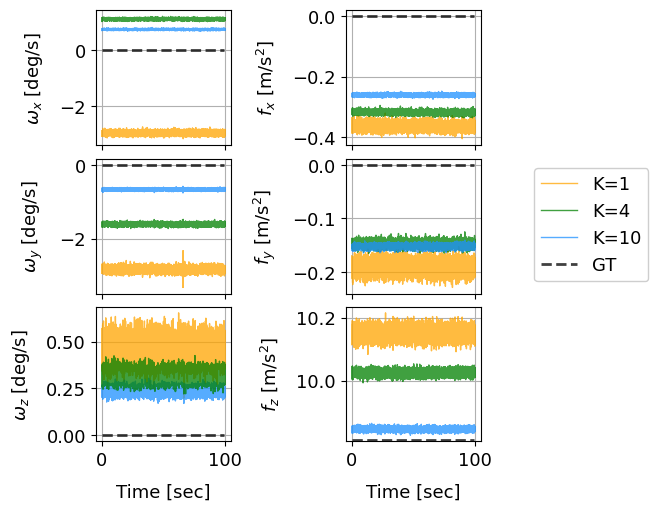

In [7]:
#@title

fig, ax = plt.subplots(3, 2, figsize=(6, 5), sharex=True, constrained_layout=True)

ax[0,0].plot(CFG.time, x_1_gyr[:,0], linewidth=1, alpha=.75, c='orange')
ax[0,0].plot(CFG.time, x_4_gyr.mean(0)[:,0], linewidth=1, alpha=.75, c='green')
ax[0,0].plot(CFG.time, x_10_gyr.mean(0)[:,0], linewidth=1, alpha=.75, c='dodgerblue')
ax[0,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[0,0].tick_params(axis='both', which='major', labelsize=13)
ax[0,0].set_ylabel(r'$\omega_{x}$ [deg/s]', fontsize=13, labelpad=10)
ax[0,0].grid(True)

ax[1,0].plot(CFG.time, x_1_gyr[:,1], linewidth=1, alpha=.75, c='orange')
ax[1,0].plot(CFG.time, x_4_gyr.mean(0)[:,1], linewidth=1, alpha=.75, c='green')
ax[1,0].plot(CFG.time, x_10_gyr.mean(0)[:,1], linewidth=1, alpha=.75, c='dodgerblue')
ax[1,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[1,0].tick_params(axis='both', which='major', labelsize=13)
ax[1,0].set_ylabel(r'$\omega_{y}$ [deg/s]', fontsize=13, labelpad=10)
ax[1,0].grid(True)

ax[2,0].plot(CFG.time, x_10_gyr[1,:,2], linewidth=1, alpha=.75, c='orange')
ax[2,0].plot(CFG.time, x_10_gyr.mean(0)[:,2], linewidth=1, alpha=.75, c='dodgerblue')
ax[2,0].plot(CFG.time, x_4_gyr.mean(0)[:,2], linewidth=1, alpha=.75, c='green')
ax[2,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[2,0].tick_params(axis='both', which='major', labelsize=13)
ax[2,0].set_ylabel(r'$\omega_{z}$ [deg/s]', fontsize=13, labelpad=10)
ax[2,0].set_xlabel(r'Time [sec]', fontsize=13, labelpad=10)
ax[2,0].grid(True)

# --------------------------------------------------------- #
# --------------------------------------------------------- #

ax[0,1].plot(CFG.time, x_1_acc[:,0], linewidth=1, alpha=.75, c='orange')
ax[0,1].plot(CFG.time, x_4_acc.mean(0)[:,0], linewidth=1, alpha=.75, c='green')
ax[0,1].plot(CFG.time, x_10_acc.mean(0)[:,0], linewidth=1, alpha=.75, c='dodgerblue')
ax[0,1].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[0,1].tick_params(axis='both', which='major', labelsize=13)
ax[0,1].set_ylabel(r'$f_{x} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[0,1].grid(True)

ax[1,1].plot(CFG.time, x_1_acc[:,1], linewidth=1, alpha=.75, c='orange')
ax[1,1].plot(CFG.time, x_4_acc.mean(0)[:,1], linewidth=1, alpha=.75, c='green')
ax[1,1].plot(CFG.time, x_10_acc.mean(0)[:,1], linewidth=1, alpha=.75, c='dodgerblue')
ax[1,1].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[1,1].tick_params(axis='both', which='major', labelsize=13)
ax[1,1].set_ylabel(r'$f_{y} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[1,1].grid(True)
ax[1,1].legend(['K=1', 'K=4', 'K=10', 'GT'], loc='upper right',
               framealpha=0.95, fontsize=13, fancybox=True, bbox_to_anchor=(2.3, 1));

ax[2,1].plot(CFG.time, x_1_acc[:,2], linewidth=1, alpha=.75, c='orange')
ax[2,1].plot(CFG.time, x_4_acc.mean(0)[:,2], linewidth=1, alpha=.75, c='green')
ax[2,1].plot(CFG.time, x_10_acc.mean(0)[:,2], linewidth=1, alpha=.75, c='dodgerblue')
ax[2,1].axhline(9.81, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[2,1].tick_params(axis='both', which='major', labelsize=13)
ax[2,1].set_ylabel(r'$f_{z} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[2,1].set_xlabel(r'Time [sec]', fontsize=13, labelpad=10)
ax[2,1].grid(True)

* $\text{Kernel density estimation (uncalibrated) }$

(5.64, 5.918466775495464)

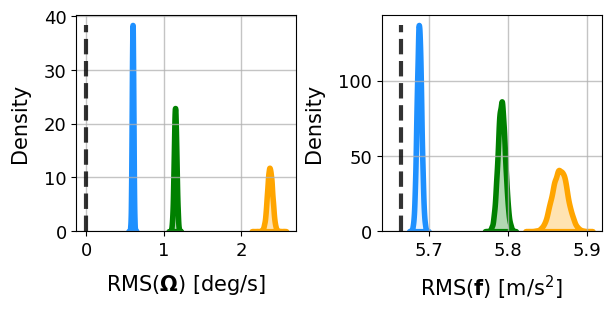

In [8]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

sn.kdeplot(x_1_RMS_gyr, lw=4, color='orange', alpha=.3, shade=True, ax=ax[0]);
sn.kdeplot(x_4_RMS_gyr , lw=4, color='green', alpha=.3, shade=True, ax=ax[0]);
sn.kdeplot(x_10_RMS_gyr, lw=4, color='dodgerblue', ls='-', alpha=.1, shade=True, ax=ax[0]);
ax[0].set_xlabel(r'RMS($\bf{\Omega}$) [deg/s]', fontsize=15, labelpad=10);
ax[0].set_ylabel(r'Density', fontsize=15, labelpad=10);
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[0].axvline(0, 0, .95, lw=3., ls='--', color='k', alpha=.8);
ax[0].tick_params(axis='both', which='major', labelsize=13)

# ---------------------------------------------------- #
g_GT = RMS( np.array([9.81, 0, 0]) )
sn.kdeplot(x_1_RMS_acc, lw=4, color='orange', alpha=.3, shade=True, ax=ax[1]);
sn.kdeplot(x_4_RMS_acc , lw=4, color='green', alpha=.3, shade=True, ax=ax[1]);
sn.kdeplot(x_10_RMS_acc, lw=4, color='dodgerblue', ls='-', alpha=.1, shade=True, ax=ax[1]);
ax[1].set_xlabel(r'RMS($\bf{f}$) [m/s$^2$]', fontsize=15, labelpad=10);
ax[1].set_ylabel(r'Density', fontsize=15, labelpad=10);
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[1].axvline(g_GT, 0, .95, lw=3., ls='--', color='k', alpha=.8);
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_xlim(left=5.64)

* $\text{Inertial measurements (calibrated)}$

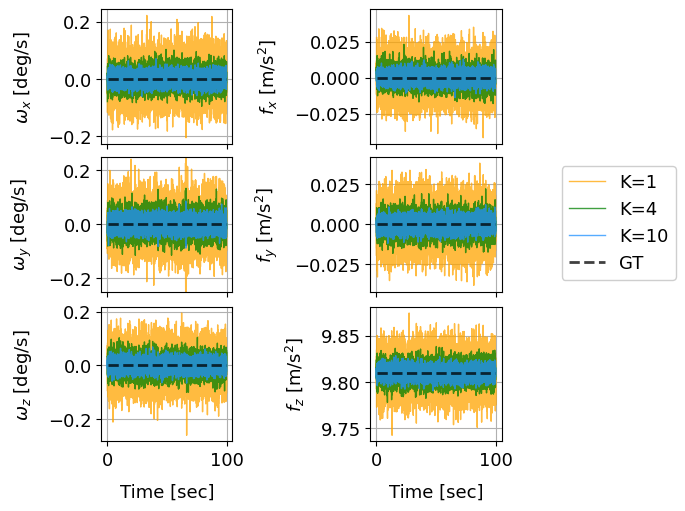

In [9]:
#@title

fig, ax = plt.subplots(3, 2, figsize=(6, 5), sharex=True, constrained_layout=True)

ax[0,0].plot(CFG.time, x_1_gyr[:,0]-x_1_gyr[:,0].mean(), linewidth=1, alpha=.75, c='orange')
ax[0,0].plot(CFG.time, x_4_gyr.mean(0)[:,0]-x_4_gyr.mean(0)[:,0].mean(), linewidth=1, alpha=.75, c='green')
ax[0,0].plot(CFG.time, x_10_gyr.mean(0)[:,0]-x_10_gyr.mean(0)[:,0].mean(), linewidth=1, alpha=.75, c='dodgerblue')
ax[0,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[0,0].tick_params(axis='both', which='major', labelsize=13)
ax[0,0].set_ylabel(r'$\omega_{x}$ [deg/s]', fontsize=13, labelpad=10)
ax[0,0].grid(True)

ax[1,0].plot(CFG.time, x_1_gyr[:,1]-x_1_gyr[:,1].mean(), linewidth=1, alpha=.75, c='orange')
ax[1,0].plot(CFG.time, x_4_gyr.mean(0)[:,1]-x_4_gyr.mean(0)[:,1].mean(), linewidth=1, alpha=.75, c='green')
ax[1,0].plot(CFG.time, x_10_gyr.mean(0)[:,1]-x_10_gyr.mean(0)[:,1].mean(), linewidth=1, alpha=.75, c='dodgerblue')
ax[1,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[1,0].tick_params(axis='both', which='major', labelsize=13)
ax[1,0].set_ylabel(r'$\omega_{y}$ [deg/s]', fontsize=13, labelpad=10)
ax[1,0].set_ylim([-.25, +.25])
ax[1,0].grid(True)

ax[2,0].plot(CFG.time, x_10_gyr[1,:,2]-x_10_gyr[1,:,2].mean(), linewidth=1, alpha=.75, c='orange')
ax[2,0].plot(CFG.time, x_4_gyr.mean(0)[:,2]-x_4_gyr.mean(0)[:,2].mean(), linewidth=1, alpha=.75, c='green')
ax[2,0].plot(CFG.time, x_10_gyr.mean(0)[:,2]-x_10_gyr.mean(0)[:,2].mean(), linewidth=1, alpha=.75, c='dodgerblue')
ax[2,0].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[2,0].tick_params(axis='both', which='major', labelsize=13)
ax[2,0].set_ylabel(r'$\omega_{z}$ [deg/s]', fontsize=13, labelpad=10)
ax[2,0].set_xlabel(r'Time [sec]', fontsize=13, labelpad=10)
ax[2,0].grid(True)

# --------------------------------------------------------- #
# --------------------------------------------------------- #

ax[0,1].plot(CFG.time, x_1_acc[:,0]-x_1_acc[:,0].mean(), linewidth=1, alpha=.75, c='orange')
ax[0,1].plot(CFG.time, x_4_acc.mean(0)[:,0]-x_4_acc.mean(0)[:,0].mean(), linewidth=1, alpha=.75, c='green')
ax[0,1].plot(CFG.time, x_10_acc.mean(0)[:,0]-x_10_acc.mean(0)[:,0].mean(), linewidth=1, alpha=.75, c='dodgerblue')
ax[0,1].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[0,1].tick_params(axis='both', which='major', labelsize=13)
ax[0,1].set_ylabel(r'$f_{x} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[0,1].grid(True)

ax[1,1].plot(CFG.time, x_1_acc[:,1]-x_1_acc[:,1].mean(), linewidth=1, alpha=.75, c='orange')
ax[1,1].plot(CFG.time, x_4_acc.mean(0)[:,1]-x_4_acc.mean(0)[:,1].mean(), linewidth=1, alpha=.75, c='green')
ax[1,1].plot(CFG.time, x_10_acc.mean(0)[:,1]-x_10_acc.mean(0)[:,1].mean(), linewidth=1, alpha=.75, c='dodgerblue')
ax[1,1].axhline(0, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[1,1].tick_params(axis='both', which='major', labelsize=13)
ax[1,1].set_ylabel(r'$f_{y} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[1,1].grid(True)
ax[1,1].legend(['K=1', 'K=4', 'K=10', 'GT'], loc='upper right',
               framealpha=0.95, fontsize=13, fancybox=True, bbox_to_anchor=(2.4, 1));

ax[2,1].plot(CFG.time, x_1_acc[:,2]-np.abs(9.81-x_1_acc[:,2].mean()), linewidth=1, alpha=.75, c='orange')
ax[2,1].plot(CFG.time, x_4_acc.mean(0)[:,2]-np.abs(9.81-x_4_acc.mean(0)[:,2].mean()), linewidth=1, alpha=.75, c='green')
ax[2,1].plot(CFG.time, x_10_acc.mean(0)[:,2]-np.abs(9.81-x_10_acc.mean(0)[:,2].mean()), linewidth=1, alpha=.75, c='dodgerblue')
ax[2,1].axhline(9.81, xmin=0.05, xmax=0.95, linewidth=2., alpha=.75, c='k', ls='--')
ax[2,1].tick_params(axis='both', which='major', labelsize=13)
ax[2,1].set_ylabel(r'$f_{z} $ [m/s$^2$]', fontsize=13, labelpad=10)
ax[2,1].set_xlabel(r'Time [sec]', fontsize=13, labelpad=10)
ax[2,1].grid(True)

* $\text{Kernel density estimation (calibrated) }$

(-0.03, 0.03)

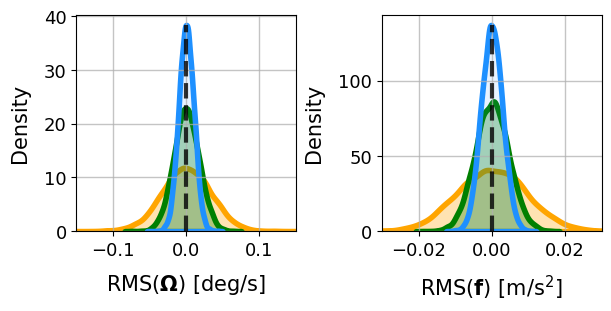

In [10]:
#@title
import seaborn as sn
fig, ax = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

x_1_RMS_gyr_N = x_1_RMS_gyr - x_1_RMS_gyr.mean()
x_4_RMS_gyr_N = x_4_RMS_gyr - x_4_RMS_gyr.mean()
x_10_RMS_gyr_N = x_10_RMS_gyr - x_10_RMS_gyr.mean()

sn.kdeplot(x_1_RMS_gyr_N, lw=4, color='orange', alpha=.3, shade=True, ax=ax[0]);
sn.kdeplot(x_4_RMS_gyr_N, lw=4, color='green', alpha=.3, shade=True, ax=ax[0]);
sn.kdeplot(x_10_RMS_gyr_N, lw=4, color='dodgerblue', ls='-', alpha=.1, shade=True, ax=ax[0]);
ax[0].set_xlabel(r'RMS($\bf{\Omega}$) [deg/s]', fontsize=15, labelpad=10);
ax[0].set_ylabel(r'Density', fontsize=15, labelpad=10);
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[0].axvline(0, 0, .95, lw=3., ls='--', color='k', alpha=.8);
ax[0].set_xlim([-0.15, +0.15])
ax[0].tick_params(axis='both', which='major', labelsize=13)

# ---------------------------------------------------- #
g_GT = RMS( np.array([9.81, 0, 0]) )
x_1_RMS_acc_N = x_1_RMS_acc-x_1_RMS_acc.mean()
x_4_RMS_acc_N = x_4_RMS_acc-x_4_RMS_acc.mean()
x_10_RMS_acc_N = x_10_RMS_acc-x_10_RMS_acc.mean()

sn.kdeplot(x_1_RMS_acc_N, lw=4, color='orange', alpha=.3, shade=True, ax=ax[1]);
sn.kdeplot(x_4_RMS_acc_N, lw=4, color='green', alpha=.3, shade=True, ax=ax[1]);
sn.kdeplot(x_10_RMS_acc_N, lw=4, color='dodgerblue', ls='-', alpha=.1, shade=True, ax=ax[1]);
ax[1].set_xlabel(r'RMS($\bf{f}$) [m/s$^2$]', fontsize=15, labelpad=10);
ax[1].set_ylabel(r'Density', fontsize=15, labelpad=10);
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[1].axvline(0, 0, .95, lw=3., ls='--', color='k', alpha=.8);
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_xlim([-0.03, +0.03])

$\text{Validation against GT}$

In order to assess the validity and optimality of our study, the processed results are compared to the technical specs stated by [manufacturer](https://www.xsens.com/hubfs/Downloads/DOT/Documents/2021-07%20-%20Archived%20-%20Xsens%20DOT%20User%20Manual%20.pdf).

Under sampling rate of 100 [Hz], noise density of a single IMU is given by:

Error source | Specs | Noise density
-------------------|------------------|-------------------|
Angle random walk  | $$ \sigma_{ARW} = 0.007 \ [\frac{deg}{s \sqrt{ Hz }}] = 0.007 \cdot \sqrt{120} = 0.07668 \ [\frac{deg}{s}]$$ | $$1.34 \ [\frac{mRad}{s}]$$
Gyro bias stability | $$\sigma_{BI} = 10 \ [ \frac{deg}{hr}]$$ | $$1/360 \ [\frac{deg}{s}]$$
Velocity random walk  | $$\sigma_{VRW} = 120 \ [\frac{\mu g}{ \sqrt{ Hz }}] = 120 ⋅ 10^{-6} ⋅ 9.81 ⋅ \sqrt{120} = 0.0129 \ [\frac{m^2}{s}] $$ | $$ 1.315 \ [mg] $$
Accel. bias stability | $$\sigma_{BI} = 0.03 \ [ mg ]$$ | $$\approx 0.0003 \ [\frac{m}{s^2}]$$

In [11]:
# Allocate memory and data structures
x_1_gyr_MA, x_4_gyr_MA, x_10_gyr_MA = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)
x_1_acc_MA, x_4_acc_MA, x_10_acc_MA = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)

x_1_gyr_SD, x_4_gyr_SD, x_10_gyr_SD = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)
x_1_acc_SD, x_4_acc_SD, x_10_acc_SD = np.zeros(CFG.t_len), np.zeros(CFG.t_len), np.zeros(CFG.t_len)

for i in range( 1, CFG.t_len ):
    idx_mn = np.sqrt(i)
    x_1_gyr_SD[i] = (x_1_RMS_gyr_N[:i]/idx_mn).std()
    x_4_gyr_SD[i] = (x_4_RMS_gyr_N[:i]/idx_mn).std()
    x_10_gyr_SD[i] = (x_10_RMS_gyr_N[:i]/idx_mn).std()

    x_1_acc_SD[i] = (x_1_RMS_acc_N[:i]/idx_mn).std()
    x_4_acc_SD[i] = (x_4_RMS_acc_N[:i]/idx_mn).std()
    x_10_acc_SD[i] = (x_10_RMS_acc_N[:i]/idx_mn).std()

# Extract noise density from specs
idx_acc_1 = 1; CRLB_acc_1 = 0.005/np.sqrt(np.arange(CFG.t_len)[:-idx_acc_1])
idx_acc_10 = 1; CRLB_acc_10 = 0.0013/np.sqrt(np.arange(CFG.t_len)[:-idx_acc_10])

idx_gyr_1 = 1; CRLB_gyr_1 = 0.018/np.sqrt(np.arange(CFG.t_len)[:-idx_gyr_1])
idx_gyr_10 = 1; CRLB_gyr_10 = 0.005/np.sqrt(np.arange(CFG.t_len)[:-idx_gyr_10])

* $\text{Variance error vs Averaging time}$

(-0.002, 0.002)

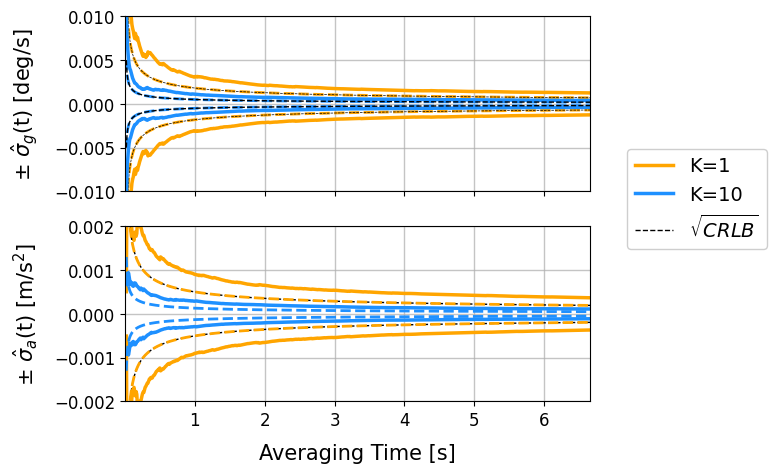

In [12]:
#@title
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[0].plot( CFG.time[2:], x_1_gyr_SD[2:], CFG.time[2:], -x_1_gyr_SD[2:], c='orange', lw=2.5 )
ax[0].plot( CFG.time[idx_gyr_1:], CRLB_gyr_1, CFG.time[idx_gyr_1:], -CRLB_gyr_1, c='orange', ls='--', lw=2.)
ax[0].plot( CFG.time[idx_gyr_1:], CRLB_gyr_1, CFG.time[idx_gyr_1:], -CRLB_gyr_1, c='k', ls='--', lw=.5)

ax[0].plot( CFG.time[2:], x_10_gyr_SD[2:], CFG.time[2:], -x_10_gyr_SD[2:], c='dodgerblue', lw=2.5 )
ax[0].plot( CFG.time[idx_gyr_10:], CRLB_gyr_10, CFG.time[idx_gyr_10:], -CRLB_gyr_10, c='dodgerblue', ls='--', lw=2.)
ax[0].plot( CFG.time[idx_gyr_10:], CRLB_gyr_10, CFG.time[idx_gyr_10:], -CRLB_gyr_10, c='k', ls='--', lw=1.)
ax[0].set_ylabel(r'$\pm \ \hat{\sigma}_g$(t) [deg/s]', fontsize=15, labelpad=10);
ax[0].set_ylim([-0.01, +0.01])
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# ----------------------------------------------------- #
ax[1].plot( CFG.time[2:], x_1_acc_SD[2:], c='orange', lw=2.5 )
ax[1].plot( CFG.time[2:], x_10_acc_SD[2:], c='dodgerblue', lw=2.5 )
ax[1].plot( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='k', ls='--', lw=1.)
ax[1].legend(['K=1', 'K=10', '$\sqrt{CRLB}$'], loc='upper right',
               framealpha=0.95, fontsize=14, fancybox=True, bbox_to_anchor=(1.4, 1.5));

ax[1].plot( CFG.time[2:], -x_10_acc_SD[2:], c='dodgerblue', lw=2.5 )
ax[1].plot( CFG.time[2:], -x_1_acc_SD[2:], c='orange', lw=2.5 )
ax[1].plot( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='orange', ls='--', lw=2.)

ax[1].plot( CFG.time[idx_acc_10:], CRLB_acc_10, CFG.time[idx_acc_10:], -CRLB_acc_10, c='dodgerblue', ls='--', lw=2.)

ax[1].set_xlabel(r'Averaging Time [s]', fontsize=15, labelpad=10);
ax[1].set_ylabel(r'$\pm \ \hat{\sigma}_a$(t) [m/s$^2$]', fontsize=15, labelpad=10);
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlim([0.005, 6.66])
ax[1].set_ylim([-0.002, +0.002])

* $\text{Variance error - semilogx plane}$

(-0.002, 0.002)

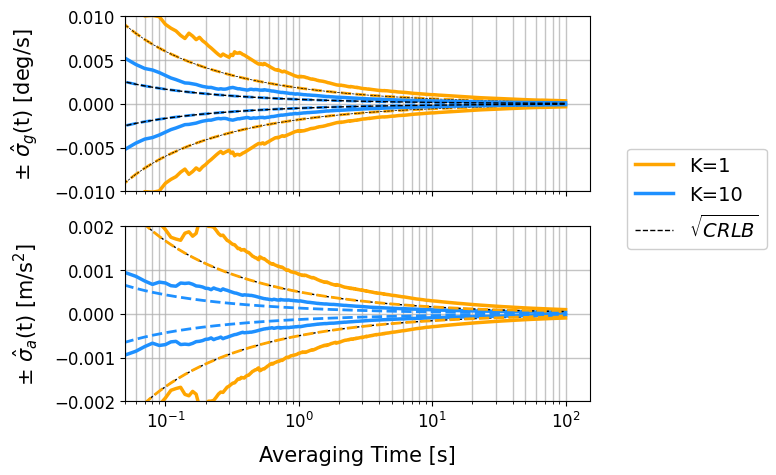

In [13]:
#@title
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[0].semilogx( CFG.time[2:], x_1_gyr_SD[2:], CFG.time[2:], -x_1_gyr_SD[2:], c='orange', lw=2.5 )
ax[0].semilogx( CFG.time[idx_gyr_1:], CRLB_gyr_1, CFG.time[idx_gyr_1:], -CRLB_gyr_1, c='orange', ls='--', lw=2.)
ax[0].semilogx( CFG.time[idx_gyr_1:], CRLB_gyr_1, CFG.time[idx_gyr_1:], -CRLB_gyr_1, c='k', ls='--', lw=.5)

ax[0].semilogx( CFG.time[2:], x_10_gyr_SD[2:], CFG.time[2:], -x_10_gyr_SD[2:], c='dodgerblue', lw=2.5 )
ax[0].semilogx( CFG.time[idx_gyr_10:], CRLB_gyr_10, CFG.time[idx_gyr_10:], -CRLB_gyr_10, c='dodgerblue', ls='--', lw=2.)
ax[0].semilogx( CFG.time[idx_gyr_10:], CRLB_gyr_10, CFG.time[idx_gyr_10:], -CRLB_gyr_10, c='k', ls='--', lw=1.)
ax[0].set_ylabel(r'$\pm \ \hat{\sigma}_g$(t) [deg/s]', fontsize=15, labelpad=10);
ax[0].set_ylim([-0.01, +0.01])
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[0].tick_params(axis='both', which='major', labelsize=12)

# ----------------------------------------------------- #
ax[1].semilogx( CFG.time[2:], x_1_acc_SD[2:], c='orange', lw=2.5 )
ax[1].semilogx( CFG.time[2:], x_10_acc_SD[2:], c='dodgerblue', lw=2.5 )
ax[1].semilogx( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='k', ls='--', lw=1.)
ax[1].legend(['K=1', 'K=10', '$\sqrt{CRLB}$'], loc='upper right',
               framealpha=0.95, fontsize=14, fancybox=True, bbox_to_anchor=(1.4, 1.5));

ax[1].semilogx( CFG.time[2:], -x_10_acc_SD[2:], c='dodgerblue', lw=2.5 )
ax[1].semilogx( CFG.time[2:], -x_1_acc_SD[2:], c='orange', lw=2.5 )
ax[1].semilogx( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='orange', ls='--', lw=2.)
ax[1].semilogx( CFG.time[idx_acc_10:], CRLB_acc_10, CFG.time[idx_acc_10:], -CRLB_acc_10, c='dodgerblue', ls='--', lw=2.)

ax[1].set_xlabel(r'Averaging Time [s]', fontsize=15, labelpad=10);
ax[1].set_ylabel(r'$\pm \ \hat{\sigma}_a$(t) [m/s$^2$]', fontsize=15, labelpad=10);
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.75)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlim(left=0.05)
ax[1].set_ylim([-0.002, +0.002])

* $\text{Variance error - log-log plane}$

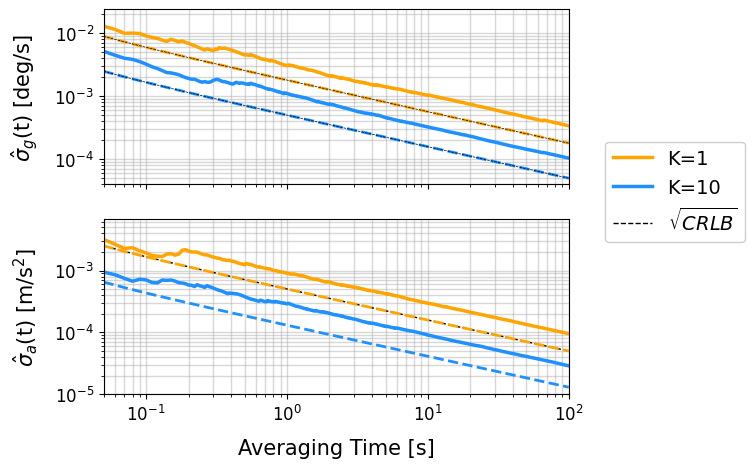

In [14]:
#@title
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[0].loglog( CFG.time[2:], x_1_gyr_SD[2:], c='orange', lw=2.5 )
ax[0].loglog( CFG.time[idx_gyr_1:], CRLB_gyr_1, c='orange', ls='--', lw=2.)
ax[0].loglog( CFG.time[idx_gyr_1:], CRLB_gyr_1, c='k', ls='--', lw=.5)

ax[0].loglog( CFG.time[2:], x_10_gyr_SD[2:], c='dodgerblue', lw=2.5 )
ax[0].loglog( CFG.time[idx_gyr_10:], CRLB_gyr_10, c='dodgerblue', ls='--', lw=2.)
ax[0].loglog( CFG.time[idx_gyr_10:], CRLB_gyr_10, c='k', ls='--', lw=.5)
ax[0].set_ylabel(r'$\hat{\sigma}_g$(t) [deg/s]', fontsize=15, labelpad=10);
ax[0].set_ylim(bottom=4e-5)
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0].tick_params(axis='both', which='major', labelsize=12)
# ------------------------------------- #

ax[1].loglog( CFG.time[2:], x_1_acc_SD[2:], c='orange', lw=2.5 )
ax[1].loglog( CFG.time[2:], x_10_acc_SD[2:], c='dodgerblue', lw=2.5 )
ax[1].loglog( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='k', ls='--', lw=1.)
ax[1].legend(['K=1', 'K=10', '$\sqrt{CRLB}$'], loc='upper right',
               framealpha=0.95, fontsize=14, fancybox=True, bbox_to_anchor=(1.4, 1.5));

ax[1].loglog( CFG.time[idx_acc_1:], CRLB_acc_1, CFG.time[idx_acc_1:], -CRLB_acc_1, c='orange', ls='--', lw=2.)
ax[1].loglog( CFG.time[idx_acc_10:], CRLB_acc_10, CFG.time[idx_acc_10:], -CRLB_acc_10, c='dodgerblue', ls='--', lw=2.)
ax[1].set_ylabel(r'$\hat{\sigma}_a$(t) [m/s$^2$]', fontsize=15, labelpad=10);
ax[1].set_ylim(bottom=1e-5)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[1].set_xlim([0.05, 100])
ax[1].set_xlabel(r'Averaging Time [s]', fontsize=15, labelpad=10);

### $\text{State Estimation}$

In this section we give the analyzed system model upon which the error is hypothesized to propagate. Let the discrete-time state-transition matrix:
\begin{align}
\delta {\mathbf{x}}_{k+1} &= \mathbf{\Phi} \, \delta {\mathbf{x}}_{k} + \mathbf{G} \textbf{w}_{k} \ .
\end{align}
where
$$
\mathbf{\Phi} =
\begin{bmatrix}
\mathbf{I}_{3} & \mathbf{I}_{3} \tau & \frac{1}{2} \mathbf{F}_{23} \tau^2 & \frac{1}{2} \mathbf{I}_{3} \tau^2 & \frac{1}{6} \mathbf{F}_{23} \tau^3 \\
\mathbf{0}_{3} & \mathbf{I}_{3} & \mathbf{F}_{23}\tau & \mathbf{I}_{3}\tau & \frac{1}{2} \mathbf{F}_{23} \tau^2 \\
\mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{I}_{3} & \mathbf{0}_{3} & \mathbf{I}_{3} \tau \\
\mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{I}_{3} & \mathbf{0}_{3} \\
\mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{0}_{3} & \mathbf{I}_{3}
\end{bmatrix} \quad ; \quad \delta {\mathbf{x}}_{k} =
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \hat{b}_a \\ \hat{b}_g \end{bmatrix}
$$

* $\text{State transition matrix}$

In [15]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

# Initialize state transition matrix
dt = 1/100
I_3, O_3  = np.eye(3), np.zeros((3,3))
g_n = np.array([0, 0, 9.81])
F_23 = skew(g_n)

p_1 = np.hstack([I_3, I_3*dt, .5*F_23*dt**2, .5*I_3*dt**2, (1/6)*F_23*dt**3])
p_2 = np.hstack([O_3,    I_3,       F_23*dt,       I_3*dt, (1/2)*F_23*dt**2])
p_3 = np.hstack([O_3,    O_3,           I_3,          O_3,           I_3*dt])
p_4 = np.hstack([O_3,    O_3,           O_3,          I_3,              O_3])
p_5 = np.hstack([O_3,    O_3,           O_3,          O_3,              I_3])

Phi = np.vstack((p_1, p_2, p_3, p_4, p_5))
G   = np.vstack((np.zeros((3,12)), np.eye(12) ))

* $\text{Error state vector}$

Initialize state vector with initial bias estimates.

In [16]:
x_1_gyr_bias, x_10_gyr_bias = x_1_gyr, x_10_gyr.mean(0)
x_1_acc_bias, x_10_acc_bias = x_1_acc, x_10_acc.mean(0)

o_3, i_3 = np.zeros(3), np.ones(3)

* $\text{Propagation in time}$

Using successive time increments (simple for-loop)

In [17]:
b_a_1 = np.array(g_n - x_1_acc_bias.mean(0) )
b_g_1 = x_1_gyr_bias.mean(0)*CFG.Deg_2_Rad       # np.linalg.norm(b_g)/3**.5

b_a_10 = np.array(g_n - x_10_acc_bias.mean(0) )
b_g_10 = x_10_gyr_bias.mean(0)*CFG.Deg_2_Rad       # np.linalg.norm(b_g)/3**.5

# Initialize vs. K
dx_1_0  = np.hstack((o_3, o_3, o_3, b_a_1, b_g_1))
dx_10_0 = np.hstack((o_3, o_3, o_3, b_a_10, b_g_10))
dx_1, dx_10 = dx_1_0, dx_10_0

dp_1,  dv_1,  de_1  = np.zeros((3, CFG.t_len)), np.zeros((3, CFG.t_len)), np.zeros((3, CFG.t_len))
dp_10, dv_10, de_10 = np.zeros((3, CFG.t_len)), np.zeros((3, CFG.t_len)), np.zeros((3, CFG.t_len))

for k in range( CFG.t_len ): #
    dx_p_1, dx_p_10 = Phi@dx_1, Phi@dx_10  # Propagate
    dx_1, dx_10 = dx_p_1, dx_p_10          # Substitute values

   # Save state variables in time
    dp_1[:,k],   dv_1[:,k],  de_1[:,k] = dx_1[0:3] , dx_1[3:6] , dx_1[6:9]
    dp_10[:,k], dv_10[:,k], de_10[:,k] = dx_10[0:3], dx_10[3:6], dx_10[6:9]

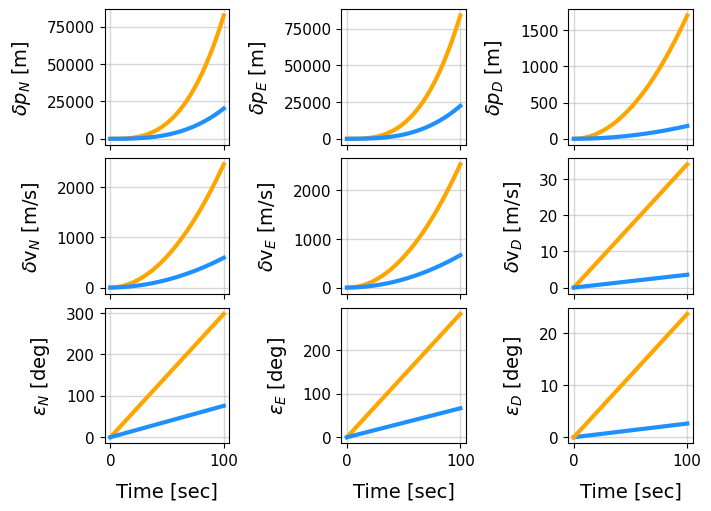

In [18]:
#@title
fig, ax = plt.subplots(3,3, figsize=(7, 5), sharex=True, constrained_layout=True)

fs, l_w = 14, 3.

### Position Error
ax[0,0].plot( CFG.time, np.abs( dp_1[0,:]),  c='orange', lw=l_w )
ax[0,0].plot( CFG.time, np.abs( dp_10[0,:]), c='dodgerblue', lw=l_w )
ax[0,0].set_ylabel(r'$\delta p_N$ [m]', fontsize=fs, labelpad=10);
ax[0,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,0].tick_params(axis='both', which='major', labelsize=11)

ax[0,1].plot( CFG.time, np.abs( dp_1[1,:]),  c='orange', lw=l_w )
ax[0,1].plot( CFG.time, np.abs( dp_10[1,:]), c='dodgerblue', lw=l_w )
ax[0,1].set_ylabel(r'$\delta p_E$ [m]', fontsize=fs, labelpad=10);
ax[0,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,1].tick_params(axis='both', which='major', labelsize=11)

ax[0,2].plot( CFG.time, np.abs( dp_1[2,:]),  c='orange', lw=l_w )
ax[0,2].plot( CFG.time, np.abs( dp_10[2,:]), c='dodgerblue', lw=l_w )
ax[0,2].set_ylabel(r'$\delta p_D$ [m]', fontsize=fs, labelpad=10);
ax[0,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,2].tick_params(axis='both', which='major', labelsize=11)

### Velocity Error
ax[1,0].plot( CFG.time, np.abs( dv_1[0,:]),  c='orange', lw=l_w )
ax[1,0].plot( CFG.time, np.abs( dv_10[0,:]), c='dodgerblue', lw=l_w )
ax[1,0].set_ylabel(r'$\delta$v$_N$ [m/s]', fontsize=fs, labelpad=10);
ax[1,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,0].tick_params(axis='both', which='major', labelsize=11)

ax[1,1].plot( CFG.time, np.abs( dv_1[1,:]),  c='orange', lw=l_w )
ax[1,1].plot( CFG.time, np.abs( dv_10[1,:]), c='dodgerblue', lw=l_w )
ax[1,1].set_ylabel(r'$\delta$v$_E$ [m/s]', fontsize=fs, labelpad=10);
ax[1,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,1].tick_params(axis='both', which='major', labelsize=11)

ax[1,2].plot( CFG.time, np.abs( dv_1[2,:]),  c='orange', lw=l_w )
ax[1,2].plot( CFG.time, np.abs( dv_10[2,:]), c='dodgerblue', lw=l_w )
ax[1,2].set_ylabel(r'$\delta$v$_D$ [m/s]', fontsize=fs, labelpad=10);
ax[1,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,2].tick_params(axis='both', which='major', labelsize=11)

### Orientation Error
ax[2,0].plot( CFG.time, np.abs( de_1[0,:]*CFG.Rad_2_Deg),  c='orange', lw=l_w )
ax[2,0].plot( CFG.time, np.abs( de_10[0,:]*CFG.Rad_2_Deg), c='dodgerblue', lw=l_w )
ax[2,0].set_ylabel(r'$\epsilon_N$ [deg]', fontsize=fs, labelpad=10);
ax[2,0].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,0].tick_params(axis='both', which='major', labelsize=11)

ax[2,1].plot( CFG.time, np.abs( de_1[1,:]*CFG.Rad_2_Deg),  c='orange', lw=l_w )
ax[2,1].plot( CFG.time, np.abs( de_10[1,:]*CFG.Rad_2_Deg), c='dodgerblue', lw=l_w )
ax[2,1].set_ylabel(r'$\epsilon_E$ [deg]', fontsize=fs, labelpad=10);
ax[2,1].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,1].tick_params(axis='both', which='major', labelsize=11)

ax[2,2].plot( CFG.time, np.abs( de_1[2,:]*CFG.Rad_2_Deg), c='dodgerblue', lw=l_w )
ax[2,2].plot( CFG.time, np.abs( de_10[2,:]*CFG.Rad_2_Deg),  c='orange', lw=l_w )
ax[2,2].set_ylabel(r'$\epsilon_D$ [deg]', fontsize=fs, labelpad=10);
ax[2,2].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,2].tick_params(axis='both', which='major', labelsize=11)

$\text{Summarize Ratios}$

* Calculate all compression ratios (division coefficient) between K_10 and K_1

In [19]:
dx_p_10 @ np.linalg.inv(np.diag(dx_p_1))

array([ 0.24525241, -0.26675748,  0.10406977,  0.24176873, -0.26272467,
        0.10406977, -0.2547498 ,  0.23464471,  9.01233641,  0.7169975 ,
        0.80028917,  0.10406977, -0.2547498 ,  0.23464471,  9.01233641])

* $\text{Error state covariance}$

Next, the error state covariance is brought for visualization :

\begin{align}
\mathbf{P}_{k+1} &= \mathbf{\Phi} \, {\mathbf{P}_{k}} \, \mathbf{\Phi}^{\text{T}} + \mathbf{Q}_k \ . % \approx \mathbf{Q}_k \ .
\end{align}
where the process noise covariance is given by

\begin{align}
& \mathbf{Q}(\tau) =
& \left[ \def\arraystretch{2.2}
\begin{array}{ccccc}
\mathbf{Q}_{ \mathbf{p}\mathbf{p} } & \mathbf{Q}_{ \mathbf{p}\mathbf{v} } & \mathbf{Q}_{ \mathbf{p}\mathbf{\epsilon} } & \frac{\sigma_{ab}^2 \tau^3  }{6} \mathbf{I}_{3} & \frac{\sigma_{gb}^2 \tau^4  }{24} \mathbf{F}_{23} \\
% ---------------------------------------------------------- %
\mathbf{Q}_{ \mathbf{p}\mathbf{v} }^{\text{T}} & \mathbf{Q}_{ \mathbf{v}\mathbf{v} } & \mathbf{Q}_{ \mathbf{v}\mathbf{\epsilon} } & \frac{\sigma_{ab}^2 \tau^2 }{2} \mathbf{I}_{3} & \frac{\sigma_{gb}^2 \tau^3  }{6} \mathbf{F}_{23} \\
% ---------------------------------------------------------- %
\mathbf{Q}_{ \mathbf{p}\mathbf{\epsilon} }^{\text{T}} & \mathbf{Q}_{ \mathbf{v}\mathbf{\epsilon} }^{\text{T}} & \mathbf{Q}_{ \mathbf{\epsilon}\mathbf{\epsilon} } & \mathbf{0}_{3} & \frac{ \sigma^2_{gb} \tau^2}{2} \mathbf{I}_{3}  \\
% ---------------------------------------------------------- %
\frac{\sigma_{ab}^2 \tau^3  }{6} \mathbf{I}_{3} & \frac{\sigma_{ab}^2 \tau^2 }{2} \mathbf{I}_{3} & \mathbf{0}_{3} & \sigma^2_{ab} \tau \mathbf{I}_{3}  & \mathbf{0}_{3} \\
% ---------------------------------------------------------- %
\frac{\sigma_{gb}^2 \tau^4  }{24} \mathbf{F}_{23}^{\text{T}} & \frac{\sigma_{gb}^2 \tau^3  }{6} \mathbf{F}_{23}^{\text{T}} & \frac{ \sigma^2_{gb}\tau^2 }{2} \mathbf{I}_{3}  & \mathbf{0}_{3} & \sigma^2_{gb} \tau\mathbf{I}_{3} \\
\end{array}
\right] \ . \notag
\end{align}
For brevity, $\mathbf{F}_{23}^{\wedge{}} = \mathbf{F}_{23} \mathbf{F}_{23}^{\text{T}}$ denotes the self-adjoint of the gravitation matrix. The diagonal elements, i.e. $\mathbf{Q}_{ii}$, denote the variability in time of each state,
\begin{align*}
\mathbf{Q}_{ \mathbf{p}\mathbf{p} } &= \frac{\sigma_{gb}^2 \mathbf{F}_{23}^{\wedge{}}  }{252} \tau^7 + \left( \frac{ \mathbf{F}_{23}^{\wedge{}} \sigma^2_{g} +  \sigma^2_{ab}\mathbf{I}_{3} }{20} \right) \tau^5 + \frac{ \sigma^2_{a}\mathbf{I}_{3} }{3} \tau^3 \ , \\
% ----------------------------------------------- %
\mathbf{Q}_{ \mathbf{v}\mathbf{v} } &= \frac{\sigma_{gb}^2 \mathbf{F}_{23}^{\wedge{}}  }{20}\tau^5 +  \left( \frac{ \mathbf{F}_{23}^{\wedge{}} \sigma^2_{g} + \mathbf{I}_{3} \sigma^2_{ab} }{3}\right) \tau^3 + \frac{ \sigma^2_{a}\mathbf{I}_{3} }{2} \tau  \ , \\
% ----------------------------------------------- %
\mathbf{Q}_{ \mathbf{\epsilon}\mathbf{\epsilon} } &= \frac{ \sigma^2_{gb}\mathbf{I}_{3}  }{3} \tau^3 + \sigma^2_{g} \mathbf{I}_{3} \tau \ . \\
\end{align*}
In contrast, the off-diagonal elements represent the degree to which different pairs of errors are intercorrelated,
\begin{align*}
\mathbf{Q}_{ \mathbf{p}\mathbf{v} } &= \frac{\sigma_{gb}^2 \mathbf{F}_{23}^{\wedge{}}  }{72}\tau^6 +  \left( \frac{ \mathbf{F}_{23}^{\wedge{}} \sigma^2_{g} + \mathbf{I}_{3} \sigma^2_{ab} }{8}\right) \tau^4 + \frac{ \sigma^2_{a}\mathbf{I}_{3} }{2} \tau^2 \ , \\
% ----------------------------------------------- %
\mathbf{Q}_{ \mathbf{p}\mathbf{\epsilon} } &= \frac{\sigma_{gb}^2 \mathbf{F}_{23} }{30} \tau^5 + \frac{\sigma_g^2 \mathbf{F}_{23}}{6} \tau^3 \ ,\\
% ----------------------------------------------- %
\mathbf{Q}_{ \mathbf{v}\mathbf{\epsilon} } &= \frac{\sigma_{gb}^2 \mathbf{F}_{23} }{8} \tau^4 + \frac{\sigma_g^2 \mathbf{F}_{23}}{2} \tau^2 \ . \end{align*}

In [20]:
#@title
# Extract calculated statdard deviations (after ~0.01 second)
std_a_1 , std_g_1  = 0.0091, 0.038*CFG.Deg_2_Rad,
std_a_10, std_g_10 = 0.0028, 0.012*CFG.Deg_2_Rad,

std_ab_1 , std_gb_1  = std_a_1 /2, std_g_1 /2
std_ab_10, std_gb_10 = std_a_10/2, std_g_10/2

# Square sigmas to get
var_a_1 , var_g_1 , var_ab_1 , var_gb_1  = std_a_1**2 , std_g_1**2 , std_ab_1**2 , std_gb_1**2
var_a_10, var_g_10, var_ab_10, var_gb_10 = std_a_10**2, std_g_10**2, std_ab_10**2, std_gb_10**2

F_SS = F_23@F_23.T

def Q_var( tt, var_a, var_g, var_ab, var_gb ):
    # Diagonals (kinematic)
    Q_pp = (var_gb*F_SS/252)*tt**7 + ( (F_SS*var_g+var_ab*I_3)/20 )*tt**5 + ( var_a*I_3/3 )*tt**3
    Q_vv = (var_gb*F_SS/20 )*tt**5 + ( (F_SS*var_g+var_ab*I_3)/3  )*tt**3 + ( var_a*I_3/2 )*tt
    Q_ee = (var_gb*I_3/3   )*tt**3 +   ( var_g*I_3 )*tt

    # Off-diagonals (kinematic)
    Q_pv = (var_gb*F_SS/72  )*tt**6 + ((F_SS*var_g+var_ab*I_3)/8 )*tt**4 + ( var_a*I_3/2 )*tt**2
    Q_pe = (var_gb*F_23/30  )*tt**5 + ((F_23*var_g)/6)*tt**3
    Q_ve = (var_gb*F_23/8   )*tt**4 + ( var_g*F_23/2 )*tt**2

    # Off-diagonals (biases)
    Q_14 = (var_ab*I_3/6)*tt**3
    Q_24 = (var_ab*I_3/2)*tt**2

    Q_15 = (var_gb*F_23/24)*tt**4
    Q_25 = (var_gb*F_23/6)*tt**3
    Q_35 = (var_gb*I_3/2)*tt**2

    Q_44 =  var_ab*I_3*tt
    Q_55 =  var_gb*I_3*tt

    # --------------------------------------------------- #
    R_1 = np.hstack((Q_pp,   Q_pv,   Q_pe, Q_14, Q_15))
    R_2 = np.hstack((Q_pv.T, Q_vv,   Q_ve, Q_24, Q_25))
    R_3 = np.hstack((Q_pe.T, Q_ve.T, Q_ee, O_3 , Q_35))
    R_4 = np.hstack((Q_14,   Q_24,   O_3 , Q_44, O_3 ))
    R_5 = np.hstack((Q_15.T, Q_25.T, Q_35, O_3 , Q_55))

    Q = np.vstack((R_1, R_2, R_3, R_4, R_5))
    return Q

In [21]:
del_t, t_tot = 0.01, 100
t_time = np.arange(0, t_tot, del_t )
t_num = int(t_tot/del_t)

Q_p_1,  Q_v_1,  Q_e_1  = np.zeros((3, t_num)), np.zeros((3, t_num)), np.zeros((3, t_num))
Q_p_10, Q_v_10, Q_e_10 = np.zeros((3, t_num)), np.zeros((3, t_num)), np.zeros((3, t_num))

for k in range(t_num):
    Q_t_1 = Q_var( k*del_t, var_a_1, var_g_1, var_ab_1, var_gb_1 )
    Q_diag_1 = np.diag( Q_t_1 )**(1/2)
    Q_p_1[:,k], Q_v_1[:,k], Q_e_1[:,k] = Q_diag_1[:3], Q_diag_1[3:6], Q_diag_1[6:9]

    Q_t_10 = Q_var( k*del_t, var_a_10, var_g_10, var_ab_10, var_gb_10 )
    Q_diag_10 = np.diag( Q_t_10 )**(1/2)
    Q_p_10[:,k], Q_v_10[:,k], Q_e_10[:,k] = Q_diag_10[:3], Q_diag_10[3:6], Q_diag_10[6:9]

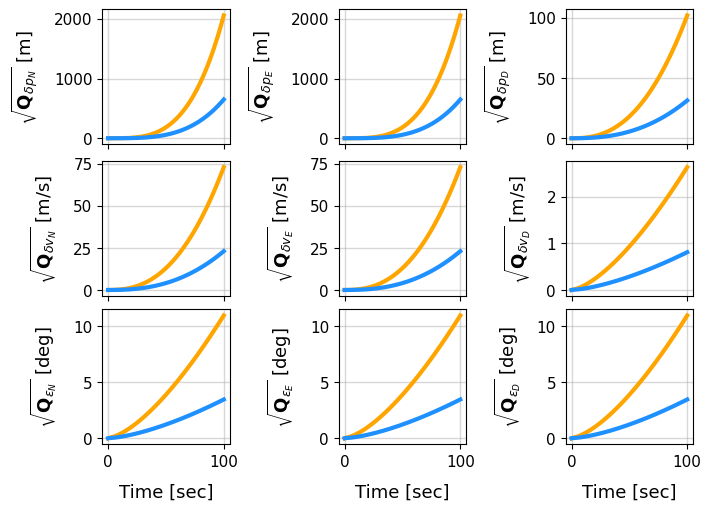

In [22]:
#@title
fig, ax = plt.subplots(3,3, figsize=(7, 5), sharex=True, constrained_layout=True)

fs, l_w = 13, 3.

### Position Error
ax[0,0].plot( t_time, Q_p_1[0,:],  c='orange', lw=l_w )
ax[0,0].plot( t_time, Q_p_10[0,:], c='dodgerblue', lw=l_w )
ax[0,0].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta p_N} } }$ [m]', fontsize=fs, labelpad=10);
ax[0,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,0].tick_params(axis='both', which='major', labelsize=11)

ax[0,1].plot( t_time, Q_p_1[1,:],  c='orange', lw=l_w )
ax[0,1].plot( t_time, Q_p_10[1,:], c='dodgerblue', lw=l_w )
ax[0,1].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta p_E} } }$ [m]', fontsize=fs, labelpad=10);
ax[0,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,1].tick_params(axis='both', which='major', labelsize=11)

ax[0,2].plot( t_time, Q_p_1[2,:],  c='orange', lw=l_w )
ax[0,2].plot( t_time, Q_p_10[2,:], c='dodgerblue', lw=l_w )
ax[0,2].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta p_D} } }$ [m]', fontsize=fs, labelpad=10);
ax[0,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0,2].tick_params(axis='both', which='major', labelsize=11)

### Velocity Error
ax[1,0].plot( t_time, Q_v_1[0,:],  c='orange', lw=l_w )
ax[1,0].plot( t_time, Q_v_10[0,:], c='dodgerblue', lw=l_w )
ax[1,0].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta v_N} } }$ [m/s]', fontsize=fs, labelpad=10);
ax[1,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,0].tick_params(axis='both', which='major', labelsize=11)

ax[1,1].plot( t_time, Q_v_1[1,:],  c='orange', lw=l_w )
ax[1,1].plot( t_time, Q_v_10[1,:], c='dodgerblue', lw=l_w )
ax[1,1].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta v_E} } }$ [m/s]', fontsize=fs, labelpad=10);
ax[1,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,1].tick_params(axis='both', which='major', labelsize=11)

ax[1,2].plot( t_time, Q_v_1[2,:],  c='orange', lw=l_w )
ax[1,2].plot( t_time, Q_v_10[2,:], c='dodgerblue', lw=l_w )
ax[1,2].set_ylabel(r'${ \sqrt{\mathbf{Q}_{\delta v_D} } }$ [m/s]', fontsize=fs, labelpad=10);
ax[1,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1,2].tick_params(axis='both', which='major', labelsize=11)

### Orientation Error
ax[2,0].plot( t_time, Q_e_1[0,:] *CFG.Rad_2_Deg,  c='orange', lw=l_w )
ax[2,0].plot( t_time, Q_e_10[0,:]*CFG.Rad_2_Deg, c='dodgerblue', lw=l_w )
ax[2,0].set_ylabel(r'${ \sqrt{\mathbf{Q}_{ \epsilon_N} } }$ [deg]', fontsize=fs, labelpad=10);
ax[2,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,0].tick_params(axis='both', which='major', labelsize=11)
ax[2,0].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);

ax[2,1].plot( t_time, Q_e_1[1,:] *CFG.Rad_2_Deg,  c='orange', lw=l_w )
ax[2,1].plot( t_time, Q_e_10[1,:]*CFG.Rad_2_Deg, c='dodgerblue', lw=l_w )
ax[2,1].set_ylabel(r'${ \sqrt{\mathbf{Q}_{ \epsilon_E} } }$ [deg]', fontsize=fs, labelpad=10);
ax[2,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,1].tick_params(axis='both', which='major', labelsize=11)
ax[2,1].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);

ax[2,2].plot( t_time, Q_e_1[2,:] *CFG.Rad_2_Deg,  c='orange', lw=l_w )
ax[2,2].plot( t_time, Q_e_10[2,:]*CFG.Rad_2_Deg, c='dodgerblue', lw=l_w )
ax[2,2].set_ylabel(r'${ \sqrt{\mathbf{Q}_{ \epsilon_D} } }$ [deg]', fontsize=fs, labelpad=10);
ax[2,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[2,2].tick_params(axis='both', which='major', labelsize=11)
ax[2,2].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);

$\text{Calculate ratios}$
* Note that **Q** is already a squared root !

In [23]:
Q_diag_10 @ np.linalg.inv( np.diag(Q_diag_1))

array([0.31576986, 0.31576986, 0.30769231, 0.31577908, 0.31577908,
       0.30769231, 0.31578947, 0.31578947, 0.31578947, 0.30769231,
       0.30769231, 0.30769231, 0.31578947, 0.31578947, 0.31578947])

* $\text{Combined visualization}$

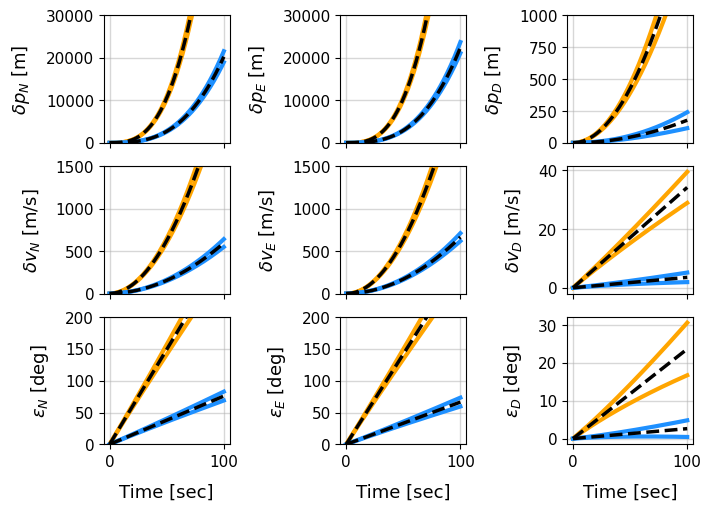

In [24]:
#@title
fs, l_w_std, l_w_mu, f_emph = 13, 3., 2.5, 2

fig, ax = plt.subplots(3,3, figsize=(7, 5), sharex=True, constrained_layout=True)

### Position Error
ax[0,0].plot( CFG.time, np.abs(dp_1[0,:] )-Q_p_1[0,:]*f_emph, CFG.time, np.abs(dp_1[0,:] )+Q_p_1[0,:]*f_emph, c='orange',lw=l_w_std )
ax[0,0].plot( CFG.time, np.abs(dp_10[0,:] )-Q_p_10[0,:]*f_emph, CFG.time, np.abs(dp_10[0,:] )+Q_p_10[0,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[0,0].plot( CFG.time, np.abs(dp_1[0,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,0].plot( CFG.time, np.abs(dp_10[0,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,0].set_ylabel(r'$\delta p_N$ [m]', fontsize=fs, labelpad=10);
ax[0,0].set_ylim([0, 30000]);
ax[0,0].tick_params(axis='both', which='major', labelsize=11)
ax[0,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[0,1].plot( CFG.time, np.abs(dp_1[1,:] )-Q_p_1[1,:]*f_emph, CFG.time, np.abs(dp_1[1,:] )+Q_p_1[1,:]*f_emph, c='orange',lw=l_w_std )
ax[0,1].plot( CFG.time, np.abs(dp_10[1,:] )-Q_p_10[1,:]*f_emph, CFG.time, np.abs(dp_10[1,:] )+Q_p_10[1,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[0,1].plot( CFG.time, np.abs(dp_1[1,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,1].plot( CFG.time, np.abs(dp_10[1,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,1].set_ylabel(r'$\delta p_E$ [m]', fontsize=fs, labelpad=10);
ax[0,1].set_ylim([0, 30000]);
ax[0,1].tick_params(axis='both', which='major', labelsize=11)
ax[0,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[0,2].plot( CFG.time, np.abs(dp_1[2,:] )-Q_p_1[2,:]*f_emph, CFG.time, np.abs(dp_1[2,:] )+Q_p_1[2,:]*f_emph, c='orange',lw=l_w_std )
ax[0,2].plot( CFG.time, np.abs(dp_10[2,:] )-Q_p_10[2,:]*f_emph, CFG.time, np.abs(dp_10[2,:] )+Q_p_10[2,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[0,2].plot( CFG.time, np.abs(dp_1[2,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,2].plot( CFG.time, np.abs(dp_10[2,:] ), c='k', ls='--',lw=l_w_mu )
ax[0,2].set_ylabel(r'$\delta p_D$ [m]', fontsize=fs, labelpad=10);
ax[0,2].set_ylim([0, 1000]);
ax[0,2].tick_params(axis='both', which='major', labelsize=11)
ax[0,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)

### Velocity Error
ax[1,0].plot( CFG.time, np.abs(dv_1[0,:] )-Q_v_1[0,:]*f_emph, CFG.time, np.abs(dv_1[0,:] )+Q_v_1[0,:]*f_emph, c='orange',lw=l_w_std )
ax[1,0].plot( CFG.time, np.abs(dv_10[0,:] )-Q_v_10[0,:]*f_emph, CFG.time, np.abs(dv_10[0,:] )+Q_v_10[0,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[1,0].plot( CFG.time, np.abs(dv_1[0,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,0].plot( CFG.time, np.abs(dv_10[0,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,0].set_ylabel(r'$\delta v_N$ [m/s]', fontsize=fs, labelpad=10);
ax[1,0].set_ylim([0, 1500]);
ax[1,0].tick_params(axis='both', which='major', labelsize=11)
ax[1,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[1,1].plot( CFG.time, np.abs(dv_1[1,:] )-Q_v_1[1,:]*f_emph, CFG.time, np.abs(dv_1[1,:] )+Q_v_1[1,:]*f_emph, c='orange',lw=l_w_std )
ax[1,1].plot( CFG.time, np.abs(dv_10[1,:] )-Q_v_10[1,:]*f_emph, CFG.time, np.abs(dv_10[1,:] )+Q_v_10[1,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[1,1].plot( CFG.time, np.abs(dv_1[1,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,1].plot( CFG.time, np.abs(dv_10[1,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,1].set_ylabel(r'$\delta v_E$ [m/s]', fontsize=fs, labelpad=10);
ax[1,1].set_ylim([0, 1500]);
ax[1,1].tick_params(axis='both', which='major', labelsize=11)
ax[1,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[1,2].plot( CFG.time, np.abs(dv_1[2,:] )-Q_v_1[2,:]*f_emph, CFG.time, np.abs(dv_1[2,:] )+Q_v_1[2,:]*f_emph, c='orange',lw=l_w_std )
ax[1,2].plot( CFG.time, np.abs(dv_10[2,:] )-Q_v_10[2,:]*f_emph, CFG.time, np.abs(dv_10[2,:] )+Q_v_10[2,:]*f_emph, c='dodgerblue',lw=l_w_std )
ax[1,2].plot( CFG.time, np.abs(dv_1[2,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,2].plot( CFG.time, np.abs(dv_10[2,:] ), c='k', ls='--',lw=l_w_mu )
ax[1,2].set_ylabel(r'$\delta v_D$ [m/s]', fontsize=fs, labelpad=10);
ax[1,2].tick_params(axis='both', which='major', labelsize=11)
ax[1,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)

### Orientation Error
ax[2,0].plot( CFG.time, (np.abs(de_1[0,:]) -Q_e_1[0,:]*f_emph)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_1[0,:] )+Q_e_1[0,:]*f_emph)*CFG.Rad_2_Deg, c='orange',lw=l_w_std )
ax[2,0].plot( CFG.time, (np.abs(de_10[0,:])-Q_e_10[0,:]*f_emph)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_10[0,:] )+Q_e_10[0,:]*f_emph)*CFG.Rad_2_Deg, c='dodgerblue',lw=l_w_std )
ax[2,0].plot( CFG.time,  np.abs(de_1[0,:]  )*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,0].plot( CFG.time,  np.abs(de_10[0,:] )*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,0].set_ylabel(r'$\epsilon_N$ [deg]', fontsize=fs, labelpad=10);
ax[2,0].set_ylim([0, 200]);
ax[2,0].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,0].tick_params(axis='both', which='major', labelsize=11)
ax[2,0].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[2,1].plot( CFG.time, (np.abs(de_1[1,:] )-Q_e_1[1,:]*f_emph)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_1[1,:] )+Q_e_1[1,:]*f_emph)*CFG.Rad_2_Deg, c='orange',lw=l_w_std )
ax[2,1].plot( CFG.time, (np.abs(de_10[1,:] )-Q_e_10[1,:]*f_emph)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_10[1,:] )+Q_e_10[1,:]*f_emph)*CFG.Rad_2_Deg, c='dodgerblue',lw=l_w_std )
ax[2,1].plot( CFG.time,  np.abs(de_1[1,:] )*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,1].plot( CFG.time,  np.abs(de_10[1,:])*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,1].set_ylabel(r'$\epsilon_E$ [deg]', fontsize=fs, labelpad=10);
ax[2,1].set_ylim([0, 200]);
ax[2,1].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,1].tick_params(axis='both', which='major', labelsize=11)
ax[2,1].grid(True, which='both', ls='-', lw=1., alpha=0.5)

ax[2,2].plot( CFG.time, (np.abs(de_10[2,:] )-Q_e_10[2,:]*f_emph)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_10[2,:] )+Q_e_10[2,:]*f_emph)*CFG.Rad_2_Deg, c='orange',lw=l_w_std )
ax[2,2].plot( CFG.time, (np.abs(de_1[2,:] )-Q_e_1[2,:]*0.2)*CFG.Rad_2_Deg, CFG.time, (np.abs(de_1[2,:] )+Q_e_1[2,:]*0.2)*CFG.Rad_2_Deg, c='dodgerblue',lw=l_w_std )
ax[2,2].plot( CFG.time,  np.abs(de_1[2,:] )*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,2].plot( CFG.time,  np.abs(de_10[2,:])*CFG.Rad_2_Deg, c='k', ls='--',lw=l_w_mu )
ax[2,2].set_ylabel(r'$\epsilon_D$ [deg]', fontsize=fs, labelpad=10);
ax[2,2].tick_params(axis='both', which='major', labelsize=11)
ax[2,2].set_xlabel(r'Time [sec]', fontsize=fs, labelpad=10);
ax[2,2].grid(True, which='both', ls='-', lw=1., alpha=0.5)

### $\text{3D Uncertainty Ellipsoid}$


Using ellipsoid to provide a geometric intuition for the confidence region within 1 standard deviation.

In [25]:
#@title
from numpy import *
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3
## Credit URL: https://scipy-cookbook.readthedocs.io/items/Matplotlib_mplot3D.html

# perform integration of u and v by substitution
u, v = r_[0:2*pi:100j], r_[0:pi:100j]

dp_N_1 , dp_E_1 , dp_D_1  = dx_p_1[0],  dx_p_1[1],  dx_p_1[2]
dp_N_10, dp_E_10, dp_D_10 = dx_p_10[0], dx_p_10[1], dx_p_10[2]

Q_N_1 , Q_E_1 , Q_D_1  = Q_diag_1[0],  Q_diag_1[1],  Q_diag_1[2]
Q_N_10, Q_E_10, Q_D_10 = Q_diag_10[0], Q_diag_10[1], Q_diag_10[2]

P_N_1  = dp_N_1  + Q_N_1*outer(cos(u),sin(v))
P_N_10 = dp_N_10 + Q_N_10*outer(cos(u),sin(v))

P_E_1  = dp_E_1  + Q_E_1*outer(sin(u),sin(v))
P_E_10 = dp_E_10 + Q_E_10*outer(sin(u),sin(v))

P_D_1  = dp_D_1  + Q_D_1*outer(ones(size(u)),cos(v))
P_D_10 = dp_D_10 + Q_D_10*outer(ones(size(u)),cos(v))

$\text{Visualize 3D uncertainty ellipsoid}$

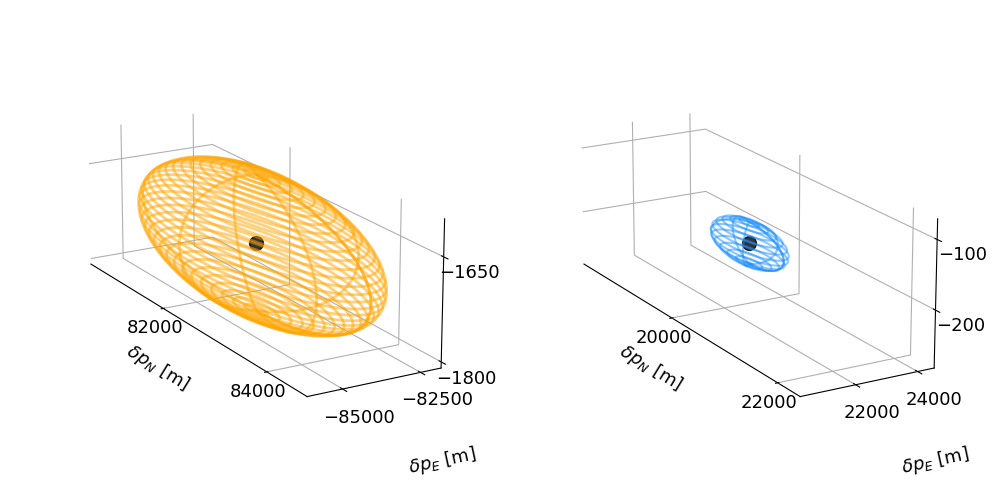

In [26]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 10))#, constrained_layout=True)

xx_lim_1 , yy_lim_1 , zz_lim_1  = [dp_N_1 - Q_N_1, dp_N_1 + Q_N_1], [dp_E_1 - Q_E_1, dp_E_1 + Q_E_1], [dp_D_1 - Q_D_1, dp_D_1 + Q_D_1]
xx_lim_10, yy_lim_10, zz_lim_10 = [dp_N_10 - Q_N_1, dp_N_10 + Q_N_1], [dp_E_10 - Q_E_1, dp_E_10 + Q_E_1], [dp_D_10 - Q_D_1, dp_D_10 + Q_D_1]

F_s = 13
ax1.plot_wireframe(P_N_1, P_E_1, P_D_1, color='orange', rstride=18, cstride=3, alpha=0.5, linewidth=2)
ax1.w_xaxis.set_pane_color('white'); ax1.w_yaxis.set_pane_color('white'); ax1.w_zaxis.set_pane_color('white')
ax1.scatter(dp_N_1, dp_E_1, dp_D_1, c='k', s=100, alpha=.8)
ax1.set_xlabel('$\delta p_N$ [m]', labelpad=25, fontsize=F_s); ax1.set_ylabel('$\delta p_E$ [m]', labelpad=25, fontsize=F_s); #ax1.set_zlabel('$\delta p_D$ [m]', labelpad=20)

# -------------------------------- #
ax2.plot_wireframe(P_N_10, P_E_10, P_D_10, color='dodgerblue', rstride=20, cstride=8, alpha=0.5)
ax2.set_xlabel('$\delta p_N$ [m]', labelpad=25, fontsize=F_s); ax2.set_ylabel('$\delta p_E$ [m]', labelpad=25, fontsize=F_s); ax2.set_zlabel('$\delta p_D$ [m]', labelpad=20, fontsize=F_s)
ax2.w_xaxis.set_pane_color('white'); ax2.w_yaxis.set_pane_color('white'); ax2.w_zaxis.set_pane_color('white')
ax2.scatter(dp_N_10, dp_E_10, dp_D_10, c='k', s=100, alpha=.8)

ax1.set_xlim(xx_lim_1); ax1.set_ylim(yy_lim_1); ax1.set_zlim(zz_lim_1);
ax2.set_xlim(xx_lim_10); ax2.set_ylim(yy_lim_10); ax2.set_zlim(zz_lim_10);

bb_x = [1.5, .5, .5]
ax1.set_box_aspect(bb_x); ax2.set_box_aspect(bb_x)
ax1.tick_params(axis='both', which='major', labelsize=F_s)

MN = 2
ax1.xaxis.set_major_locator(plt.MaxNLocator(MN)); ax1.yaxis.set_major_locator(plt.MaxNLocator(MN)); ax1.zaxis.set_major_locator(plt.MaxNLocator(MN));
ax2.xaxis.set_major_locator(plt.MaxNLocator(MN)); ax2.yaxis.set_major_locator(plt.MaxNLocator(MN)); ax2.zaxis.set_major_locator(plt.MaxNLocator(MN));
ax2.tick_params(axis='both', which='major', labelsize=F_s)

Elev, Azim = 18, -30
ax1.view_init(elev=Elev, azim=Azim)
ax2.view_init(elev=Elev, azim=Azim)
plt.tight_layout(pad=1.0)
plt.show()